## API로 이미지 불러와서 크롭

### 라이브러리 import

In [1]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [ ]:
# Azure Custom Vision API 정보 (사용자가 직접 입력)



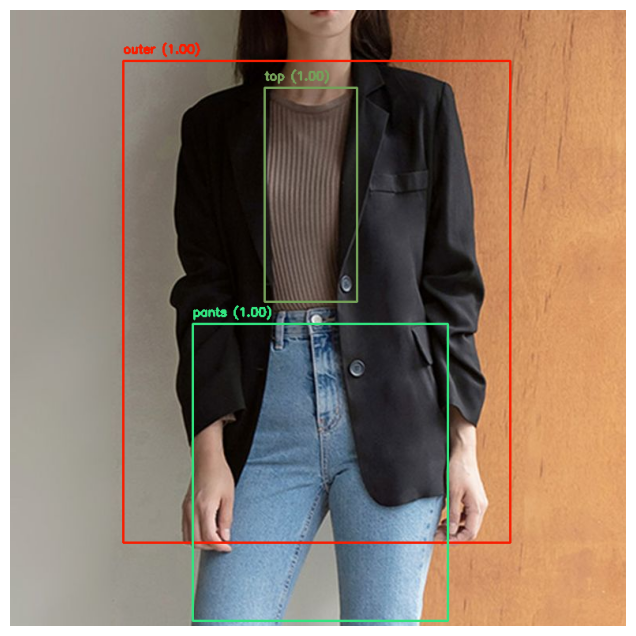

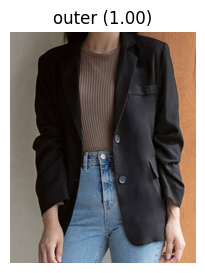

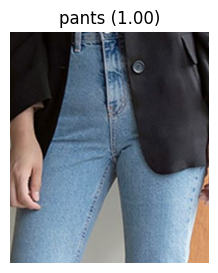

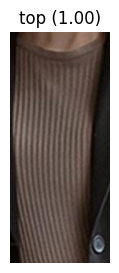

Tag: outer, Probability: 1.00, Image Shape: (610, 490, 3)
Tag: pants, Probability: 1.00, Image Shape: (376, 323, 3)
Tag: top, Probability: 1.00, Image Shape: (271, 117, 3)


In [ ]:
## Custom Vision 결과 확인
# 임계값 설정
THRESHOLD = 0.7  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 카테고리별 색상 선택
        color = category_colors[tag_name]

        # 바운딩 박스 및 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = "data/musinsa_images_outer/O10.jpg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)






## 필요한 부분만 가져오기
def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

        # 새 창에 개별 이미지 출력
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.title(f"{tag_name} ({probability:.2f})")
        plt.axis("off")
        plt.show()

    return cropped_images  # 크롭된 이미지 리스트 반환

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")



## 색상을 추출하여 반환 - 네모데이터 이용


Analyzing colors for outer (confidence: 1.00)


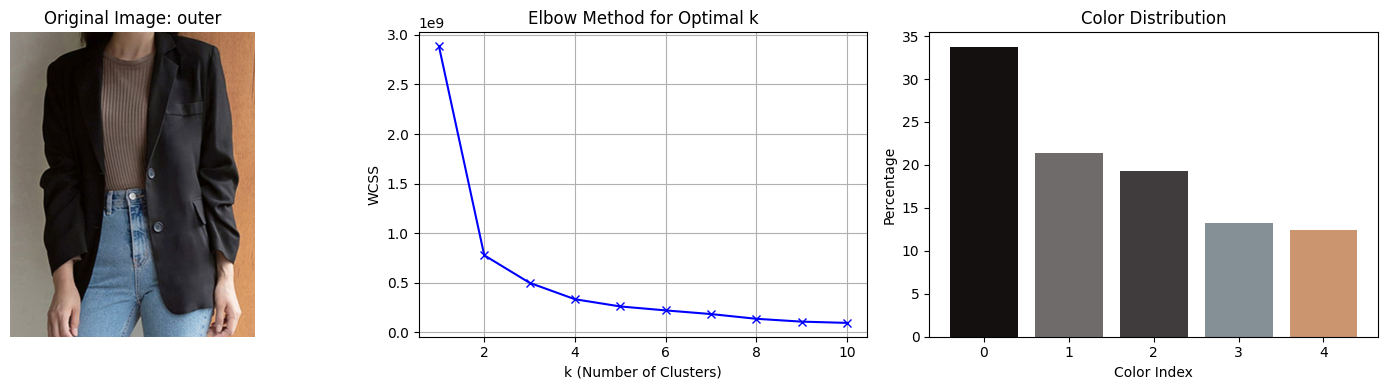


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#13100f    (19, 16, 15)         33.7%
#6f6b6a    (111, 107, 106)      21.3%
#403b3d    (64, 59, 61)         19.3%
#848f96    (132, 143, 150)      13.2%
#cb9570    (203, 149, 112)      12.5%

Analyzing colors for pants (confidence: 1.00)


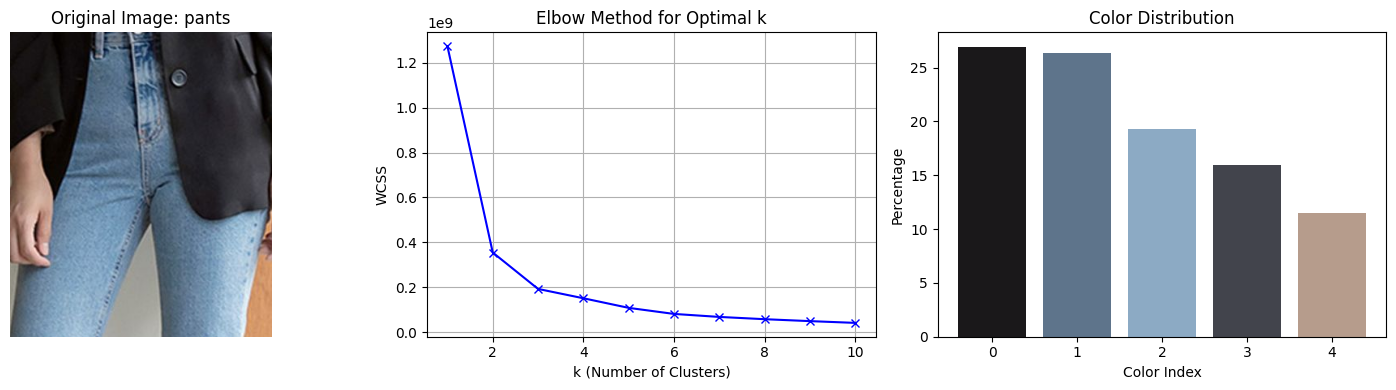


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#1a181a    (26, 24, 26)         26.9%
#5e748b    (94, 116, 139)       26.4%
#8caac4    (140, 170, 196)      19.3%
#42444c    (66, 68, 76)         15.9%
#b69c8c    (182, 156, 140)      11.5%

Analyzing colors for top (confidence: 1.00)


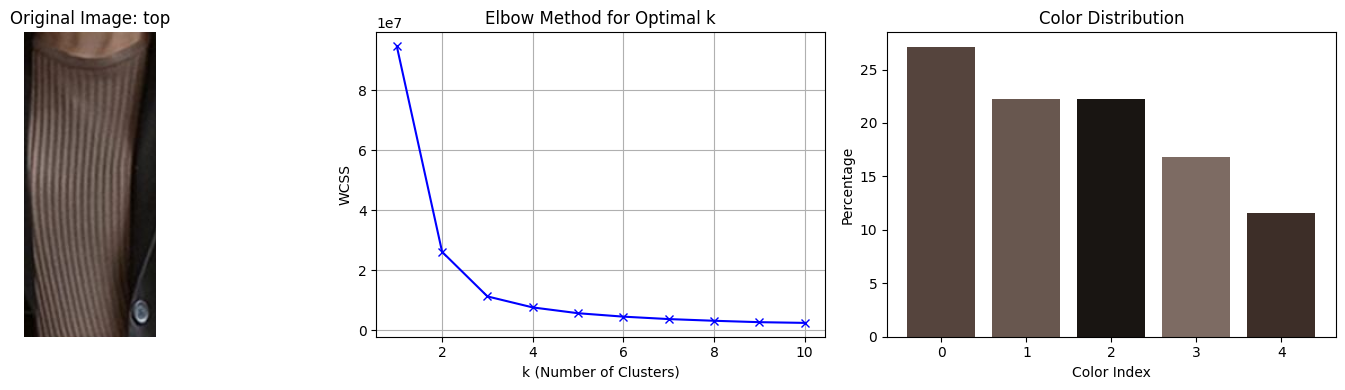


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#55443d    (85, 68, 61)         27.1%
#68574f    (104, 87, 79)        22.3%
#191512    (25, 21, 18)         22.2%
#7d6b63    (125, 107, 99)       16.8%
#3d2e28    (61, 46, 40)         11.6%


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def rgb_to_hex(rgb):
    """RGB 값을 HEX 코드로 변환"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    """
    Elbow method를 위한 WCSS(Within-Cluster Sum of Squares) 계산
    """
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def extract_dominant_colors(image, n_colors=5):
    """
    이미지에서 주요 색상을 추출하는 함수
    
    Args:
        image: RGB 형식의 이미지 배열
        n_colors: 추출할 색상의 수
    
    Returns:
        colors: 주요 색상들의 RGB 값 리스트
        percentages: 각 색상의 비율
        pixels: 원본 픽셀 데이터
    """
    pixels = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())
    
    percentages = []
    sorted_colors = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        percentages.append(percentage)
        sorted_colors.append(colors[i])
    
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = np.array(sorted_colors)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]
    
    return sorted_colors, sorted_percentages, pixels

def visualize_color_palette(colors, percentages):
    """색상 팔레트 시각화"""
    fig, ax = plt.subplots(figsize=(8, 1))
    
    start_x = 0
    for color, percentage in zip(colors, percentages):
        width = percentage / 100
        rect = Rectangle((start_x, 0), width, 1, facecolor=rgb_to_hex(color))
        ax.add_patch(rect)
        
        hex_code = rgb_to_hex(color)
        ax.text(start_x + width/2, 0.5, f'{hex_code}\n{percentage:.1f}%',
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
        
        start_x += width
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    return fig

def analyze_colors_for_cropped_objects(cropped_objects, n_colors=5):
    """
    크롭된 객체들의 색상을 분석하는 함수
    """
    for tag, prob, img in cropped_objects:
        print(f"\nAnalyzing colors for {tag} (confidence: {prob:.2f})")
        
        # 주요 색상 추출 및 WCSS 계산
        colors, percentages, pixels = extract_dominant_colors(img, n_colors)
        wcss = calculate_wcss(pixels)
        
        # 서브플롯 설정
        fig = plt.figure(figsize=(15, 4))
        
        # 1. 원본 이미지
        plt.subplot(131)
        plt.imshow(img)
        plt.title(f"Original Image: {tag}")
        plt.axis('off')
        
        # 2. Elbow 곡선
        plt.subplot(132)
        plt.plot(range(1, len(wcss) + 1), wcss, 'bx-')
        plt.xlabel('k (Number of Clusters)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        
        # 3. 색상 팔레트
        plt.subplot(133)
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            plt.bar(i, percentage, color=rgb_to_hex(color), 
                   label=f'{rgb_to_hex(color)} ({percentage:.1f}%)')
        plt.title('Color Distribution')
        plt.xlabel('Color Index')
        plt.ylabel('Percentage')
        
        plt.tight_layout()
        plt.show()
        
        # 색상 정보 표로 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")

# 실행 예시
if cropped_objects:
    analyze_colors_for_cropped_objects(cropped_objects)

### 클러스터링 성능 평가

3D scatterplot


Analyzing colors for outer (confidence: 1.00)


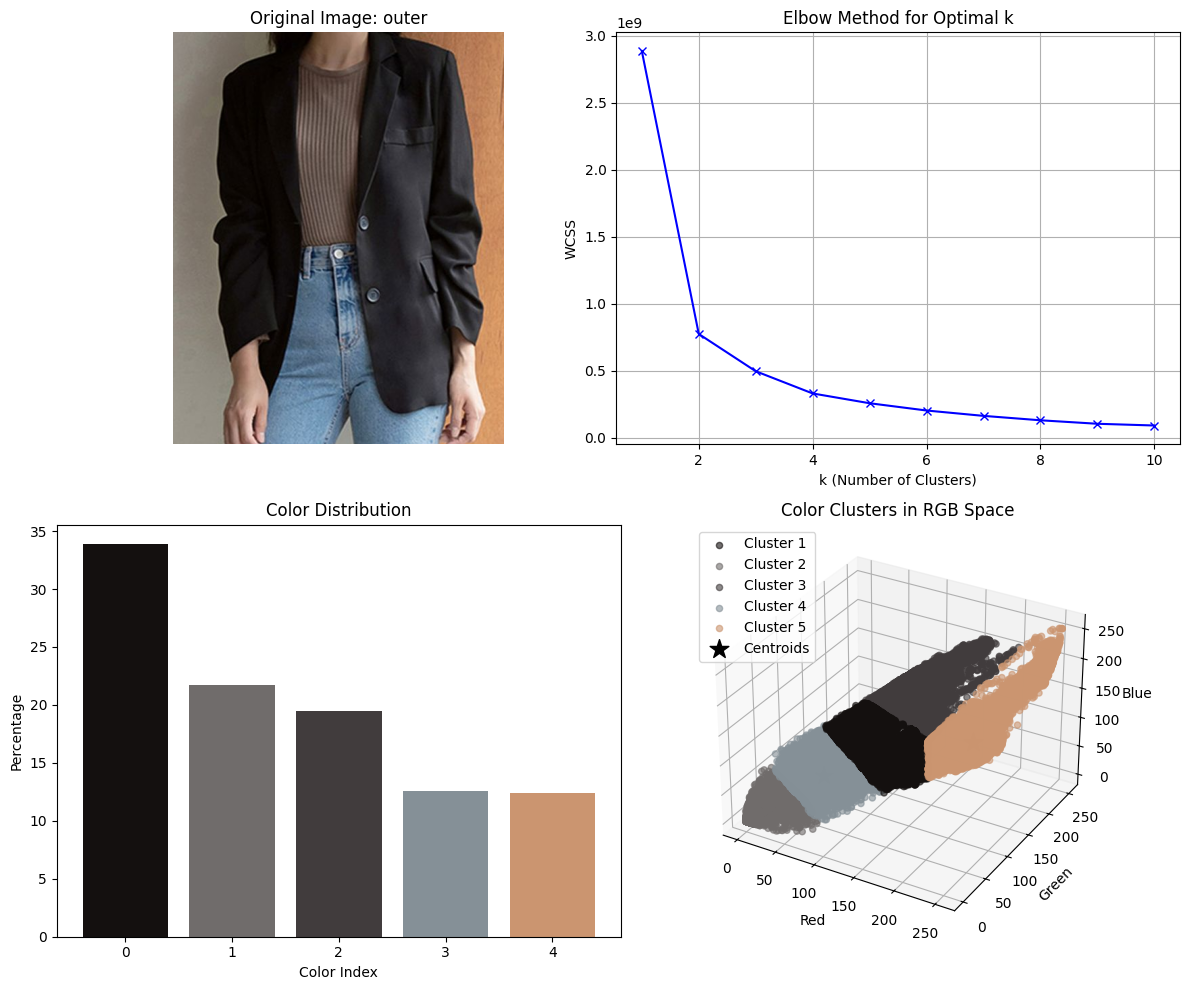


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#14100f    (20, 16, 15)         33.8%
#706c6b    (112, 108, 107)      21.7%
#413c3d    (65, 60, 61)         19.5%
#859097    (133, 144, 151)      12.5%
#cb9570    (203, 149, 112)      12.4%

Analyzing colors for pants (confidence: 1.00)


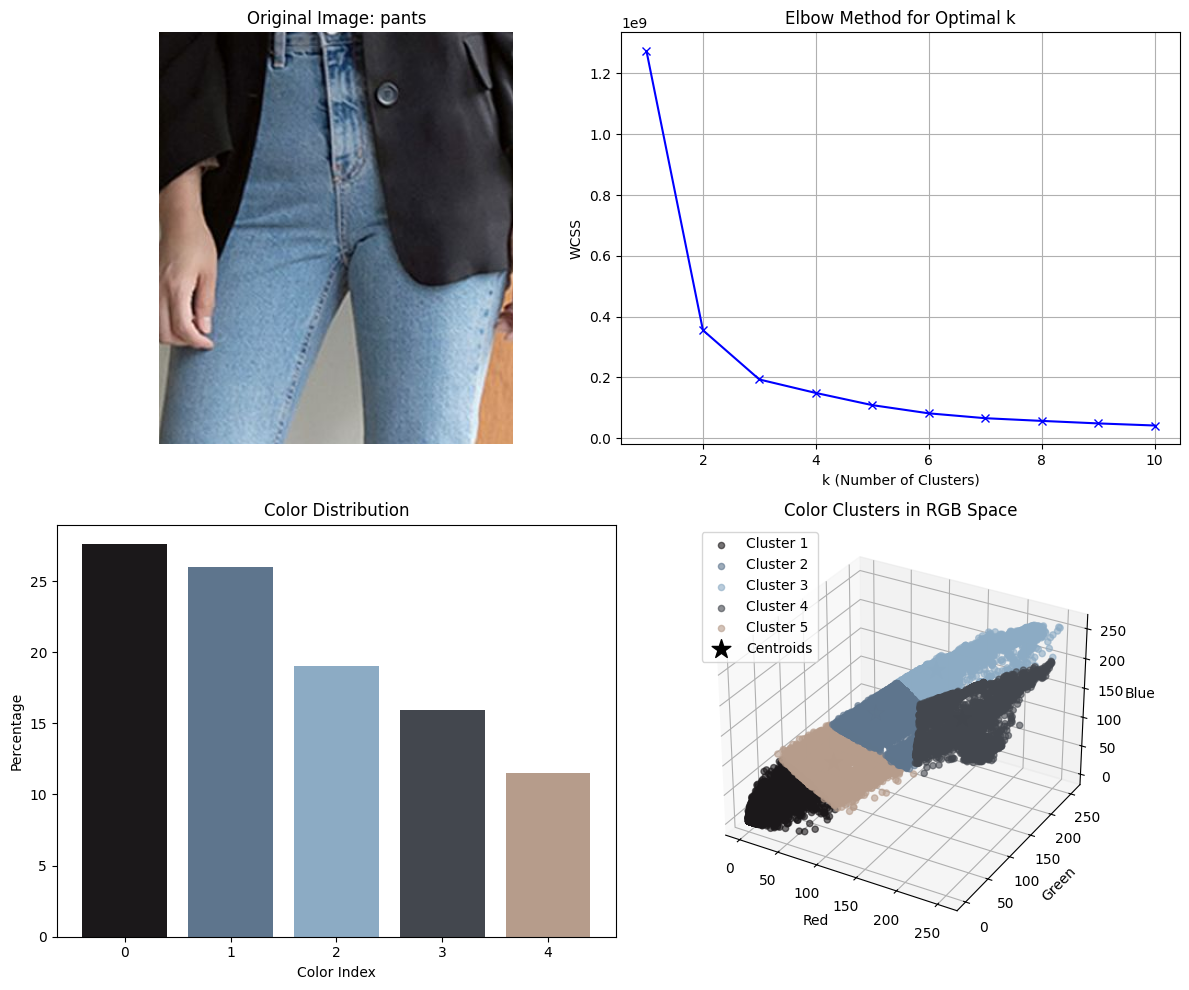


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#1b181a    (27, 24, 26)         27.6%
#5e758d    (94, 117, 141)       26.0%
#8cabc4    (140, 171, 196)      19.0%
#43474e    (67, 71, 78)         15.9%
#b69c8b    (182, 156, 139)      11.5%

Analyzing colors for top (confidence: 1.00)


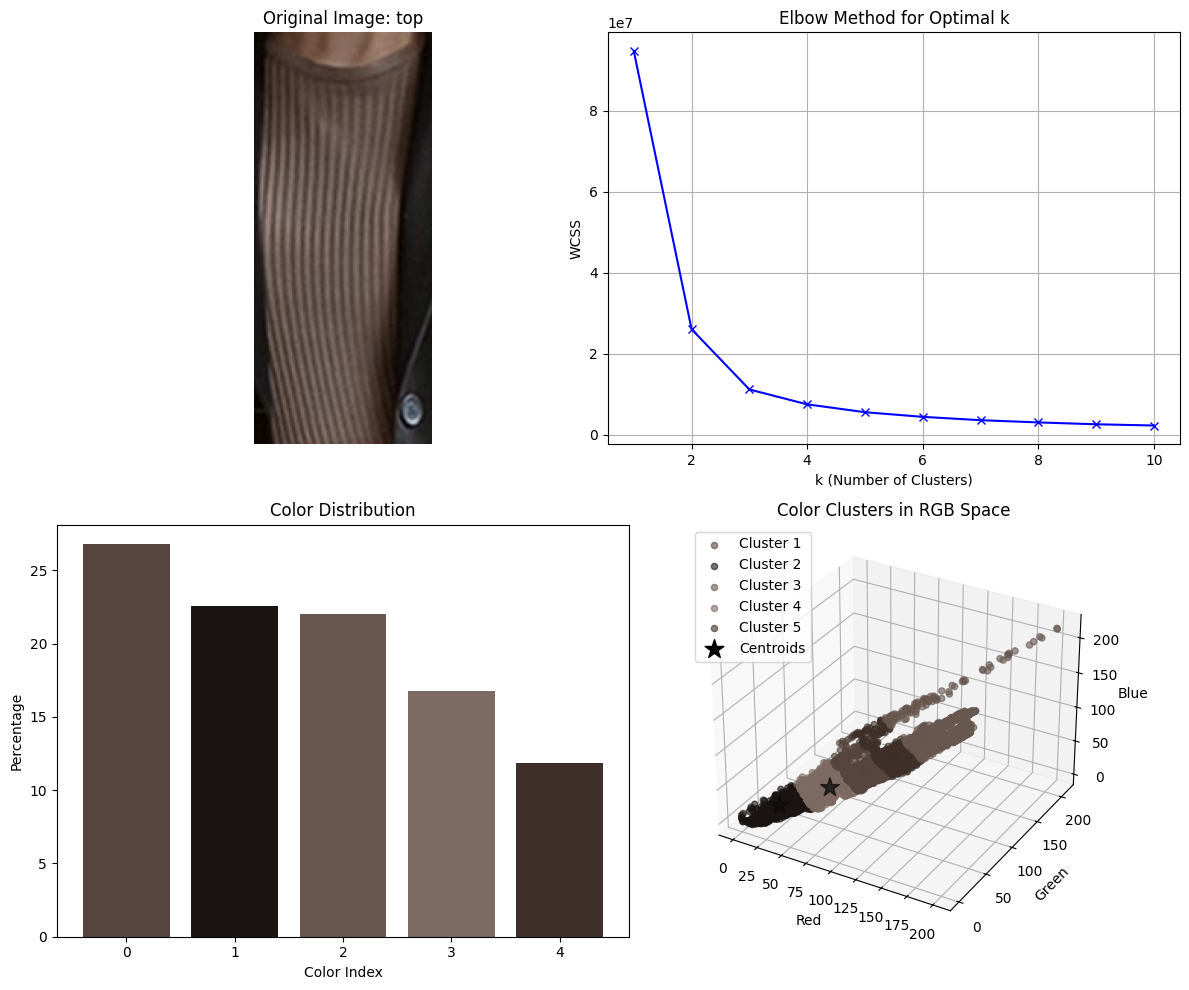


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#55453e    (85, 69, 62)         26.8%
#1a1512    (26, 21, 18)         22.6%
#68574f    (104, 87, 79)        22.0%
#7d6b63    (125, 107, 99)       16.8%
#3e3029    (62, 48, 41)         11.9%


In [28]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def extract_dominant_colors(image, n_colors=5):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_

    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())

    percentages = np.array([label_counts[i] / total_pixels * 100 for i in range(n_colors)])
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = colors[sorted_indices]
    sorted_percentages = percentages[sorted_indices]

    return sorted_colors, sorted_percentages, pixels, kmeans

def analyze_colors_for_cropped_objects(cropped_objects, n_colors=5):
    for tag, prob, img in cropped_objects:
        print(f"\nAnalyzing colors for {tag} (confidence: {prob:.2f})")

        colors, percentages, pixels, kmeans = extract_dominant_colors(img, n_colors)
        wcss = calculate_wcss(pixels)

        # 🎨 2×2 그래프 레이아웃 설정
        fig = plt.figure(figsize=(12, 10))

        # 1. 원본 이미지 (좌상단)
        plt.subplot(221)
        plt.imshow(img)
        plt.title(f"Original Image: {tag}")
        plt.axis('off')

        # 2. Elbow Method (우상단)
        plt.subplot(222)
        plt.plot(range(1, len(wcss) + 1), wcss, 'bx-')
        plt.xlabel('k (Number of Clusters)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)

        # 3. 색상 분포 (좌하단)
        plt.subplot(223)
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            plt.bar(i, percentage, color=rgb_to_hex(color))
        plt.title('Color Distribution')
        plt.xlabel('Color Index')
        plt.ylabel('Percentage')

        # 4. Scatter Plot (우하단)
        ax = plt.subplot(224, projection='3d')
        for i in range(len(colors)):
            cluster_mask = kmeans.labels_ == i
            cluster_points = pixels[cluster_mask]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                       c=[rgb_to_hex(colors[i])], label=f'Cluster {i+1}', alpha=0.6)
        
        ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2], c='black', marker='*', s=200, label='Centroids')
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')
        ax.set_title('Color Clusters in RGB Space')
        ax.legend()

        plt.tight_layout()
        plt.show()

        # 색상 정보 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")

# 실행 예시
if cropped_objects:
    analyze_colors_for_cropped_objects(cropped_objects)


#### Blue와 Yellow로 2차원 클러스터링


Analyzing colors for outer (confidence: 1.00)


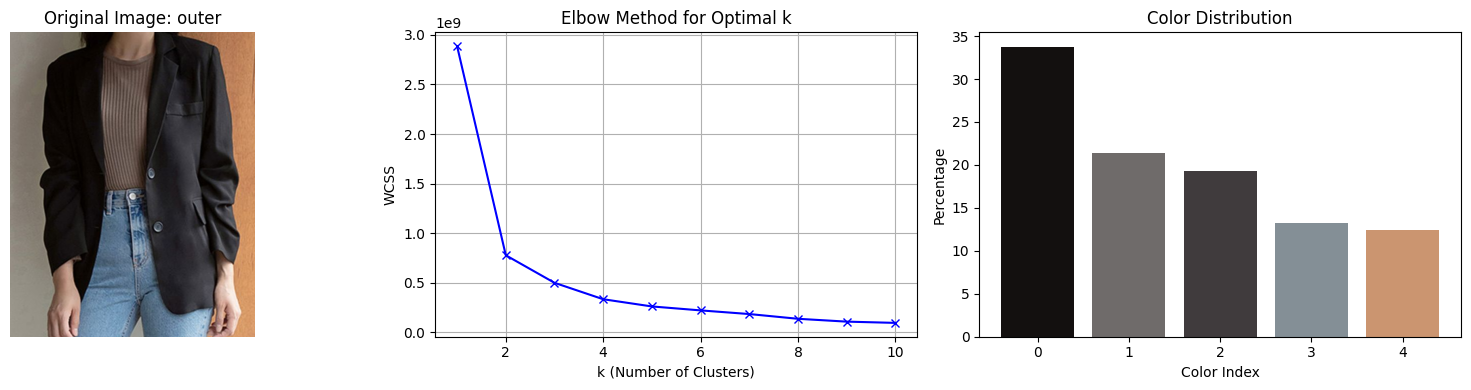

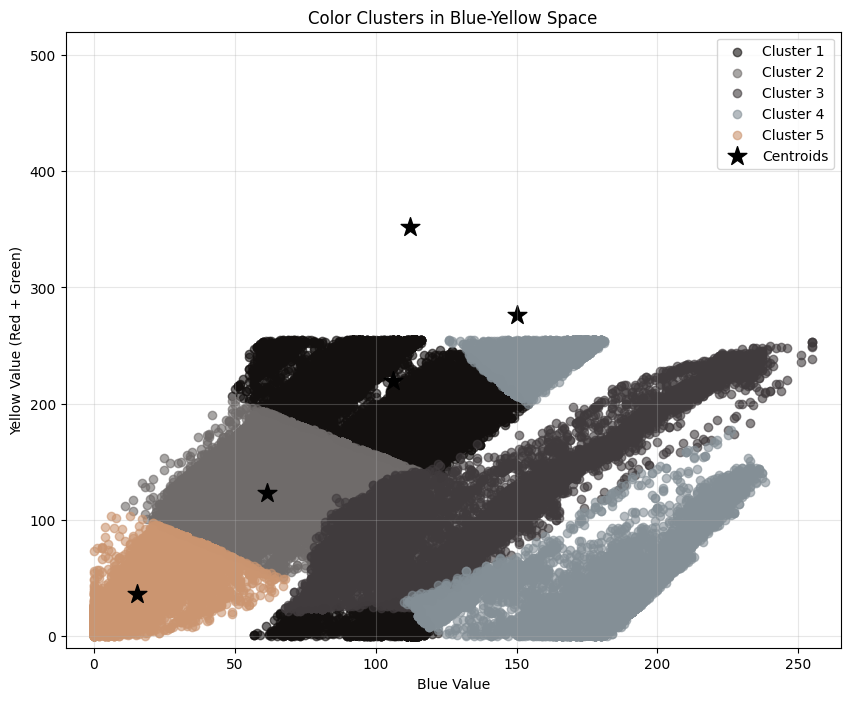


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#13100f    (19, 16, 15)         33.7%
#6f6b6a    (111, 107, 106)      21.3%
#403b3d    (64, 59, 61)         19.3%
#848f96    (132, 143, 150)      13.2%
#cb9570    (203, 149, 112)      12.5%

Analyzing colors for pants (confidence: 1.00)


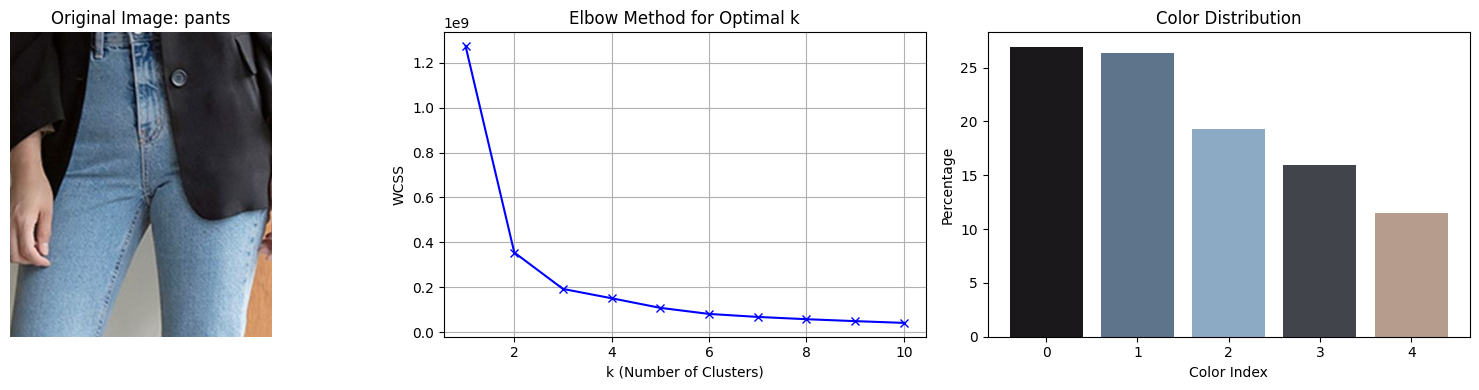

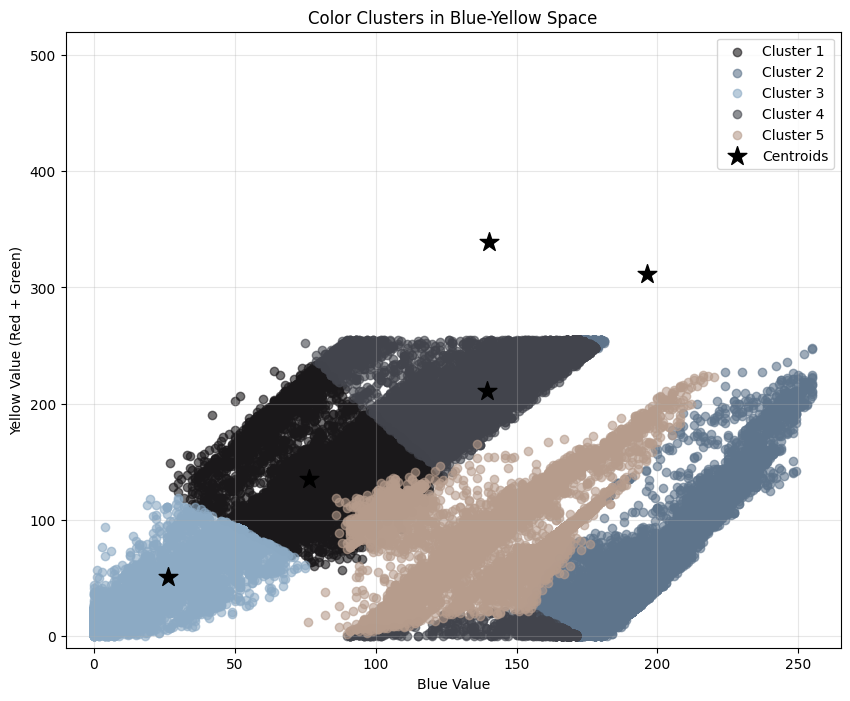


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#1a181a    (26, 24, 26)         26.9%
#5e748b    (94, 116, 139)       26.4%
#8caac4    (140, 170, 196)      19.3%
#42444c    (66, 68, 76)         15.9%
#b69c8c    (182, 156, 140)      11.5%

Analyzing colors for top (confidence: 1.00)


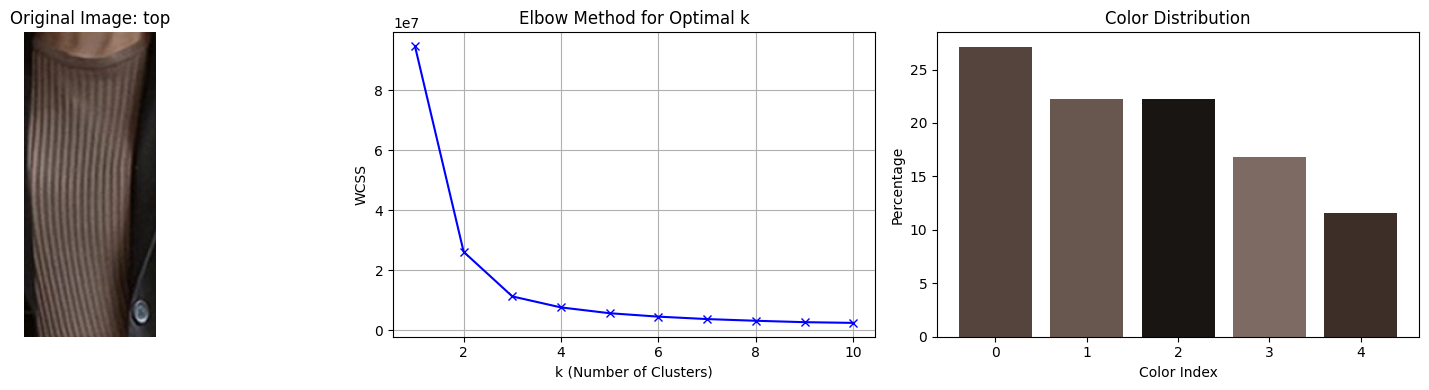

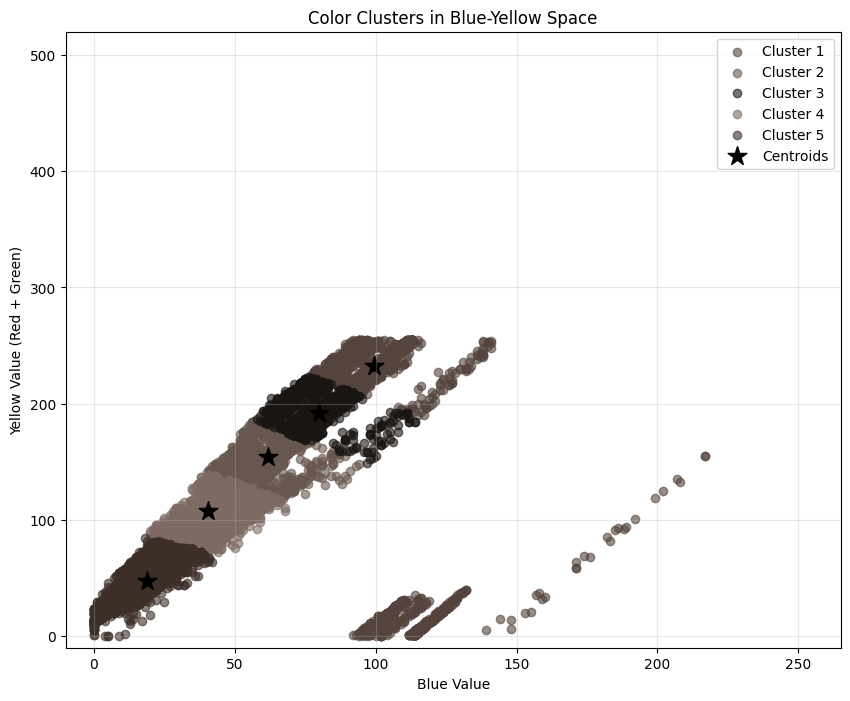


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#55443d    (85, 68, 61)         27.1%
#68574f    (104, 87, 79)        22.3%
#191512    (25, 21, 18)         22.2%
#7d6b63    (125, 107, 99)       16.8%
#3d2e28    (61, 46, 40)         11.6%


In [41]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def rgb_to_hex(rgb):
    """RGB 값을 HEX 코드로 변환"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    """
    Elbow method를 위한 WCSS(Within-Cluster Sum of Squares) 계산
    """
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def plot_color_clusters_2d(pixels, kmeans, colors):
    """
    K-means 클러스터링 결과를 2D scatter plot으로 시각화
    x축: Blue
    y축: Yellow (Red + Green)
    
    Args:
        pixels: 분석에 사용된 픽셀 데이터 (RGB)
        kmeans: 학습된 KMeans 모델
        colors: 추출된 주요 색상들
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # RGB를 Blue와 Yellow(Red+Green) 값으로 변환
    blue_values = pixels[:, 2]  # Blue 값
    yellow_values = pixels[:, 0] + pixels[:, 1]  # Red + Green 값
    
    # 클러스터 중심점도 같은 방식으로 변환
    centroids_blue = colors[:, 2]
    centroids_yellow = colors[:, 0] + colors[:, 1]
    
    # 각 클러스터별로 점들을 다른 색상으로 표시
    for i in range(len(colors)):
        cluster_mask = kmeans.labels_ == i
        ax.scatter(blue_values[cluster_mask], 
                  yellow_values[cluster_mask],
                  c=[rgb_to_hex(colors[i])],
                  label=f'Cluster {i+1}',
                  alpha=0.6)
    
    # 클러스터 중심점 표시
    ax.scatter(centroids_blue, centroids_yellow,
              c='black', marker='*', s=200,
              label='Centroids')
    
    ax.set_xlabel('Blue Value')
    ax.set_ylabel('Yellow Value (Red + Green)')
    ax.set_title('Color Clusters in Blue-Yellow Space')
    ax.legend()
    
    # 축 범위 설정 (RGB 값의 범위는 0-255이지만, Yellow는 Red+Green이므로 0-510)
    ax.set_xlim(-10, 265)  # Blue 축
    ax.set_ylim(-10, 520)  # Yellow 축
    
    # 그리드 추가
    ax.grid(True, alpha=0.3)
    
    return fig

def extract_dominant_colors(image, n_colors=5):
    """
    이미지에서 주요 색상을 추출하는 함수
    
    Args:
        image: RGB 형식의 이미지 배열
        n_colors: 추출할 색상의 수
    
    Returns:
        colors: 주요 색상들의 RGB 값 리스트
        percentages: 각 색상의 비율
        pixels: 원본 픽셀 데이터
        kmeans: 학습된 KMeans 모델
    """
    pixels = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())
    
    percentages = []
    sorted_colors = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        percentages.append(percentage)
        sorted_colors.append(colors[i])
    
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = np.array(sorted_colors)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]
    
    return sorted_colors, sorted_percentages, pixels, kmeans

def visualize_color_palette(colors, percentages):
    """색상 팔레트 시각화"""
    fig, ax = plt.subplots(figsize=(8, 1))
    
    start_x = 0
    for color, percentage in zip(colors, percentages):
        width = percentage / 100
        rect = Rectangle((start_x, 0), width, 1, facecolor=rgb_to_hex(color))
        ax.add_patch(rect)
        
        hex_code = rgb_to_hex(color)
        ax.text(start_x + width/2, 0.5, f'{hex_code}\n{percentage:.1f}%',
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
        
        start_x += width
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    return fig

def analyze_colors_for_cropped_objects(cropped_objects, n_colors=5):
    """
    크롭된 객체들의 색상을 분석하는 함수
    """
    for tag, prob, img in cropped_objects:
        print(f"\nAnalyzing colors for {tag} (confidence: {prob:.2f})")
        
        # 주요 색상 추출 및 WCSS 계산
        colors, percentages, pixels, kmeans = extract_dominant_colors(img, n_colors)
        wcss = calculate_wcss(pixels)
        
        # 서브플롯 설정
        fig = plt.figure(figsize=(16, 4))  # 기존 20 → 16으로 줄임
        
        # 1. 원본 이미지
        plt.subplot(131)  # 141 → 131 (총 3개의 그래프로 변경)
        plt.imshow(img)
        plt.title(f"Original Image: {tag}")
        plt.axis('off')
        
        # 2. Elbow 곡선
        plt.subplot(132)  # 142 → 132
        plt.plot(range(1, len(wcss) + 1), wcss, 'bx-')
        plt.xlabel('k (Number of Clusters)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        
        # 3. 색상 팔레트
        plt.subplot(133)  # 143 → 133
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            plt.bar(i, percentage, color=rgb_to_hex(color), 
                   label=f'{rgb_to_hex(color)} ({percentage:.1f}%)')
        plt.title('Color Distribution')
        plt.xlabel('Color Index')
        plt.ylabel('Percentage')

        plt.tight_layout()
        plt.show()
        
        # 4. Scatter plot 별도 표시
        scatter_fig = plot_color_clusters_2d(pixels, kmeans, colors)
        plt.show(scatter_fig)  # 별도로 표시
        
        # 색상 정보 표로 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")


# 실행 예시
if cropped_objects:
    analyze_colors_for_cropped_objects(cropped_objects)

## Outline data 로 실험

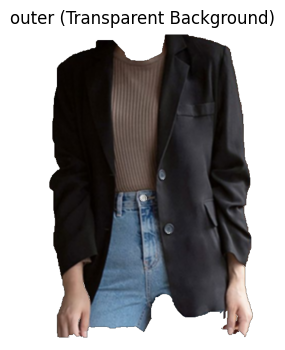

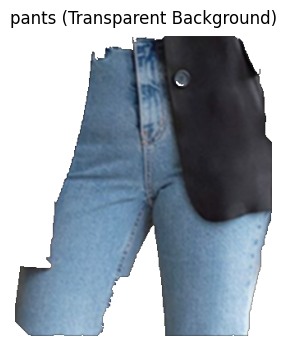

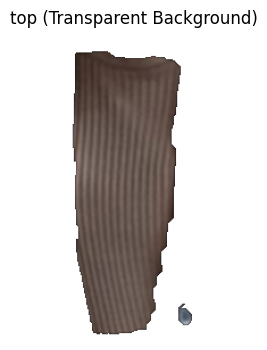

In [6]:
def remove_background(cropped_images):
    final_images = []  # 최종 결과 저장

    for tag, prob, img in cropped_images:
        h, w, _ = img.shape
        
        # 초기 마스크 설정
        mask = np.zeros((h, w), np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        
        # GrabCut을 위한 초기 사각형 (조금 작게 설정)
        rect = (5, 5, w-10, h-10)
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        
        # 배경과 전경 분리
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        result = img * mask2[:, :, np.newaxis]
        
        # 경계 부드럽게 (가우시안 블러 적용)
        blurred = cv2.GaussianBlur(result, (5, 5), 0)

        # 알파 채널 추가
        alpha = mask2 * 255
        rgba = np.dstack([blurred, alpha])

        # 📌 최종 이미지 출력
        plt.figure(figsize=(4, 4))
        plt.imshow(rgba)
        plt.title(f"{tag} (Transparent Background)", fontsize=12)
        plt.axis("off")
        plt.show()

        final_images.append((tag, rgba))  # 결과 저장
    
    return final_images  # 최종 이미지 반환

# 🔥 실행
final_results = remove_background(cropped_objects)


Analyzing colors for outer


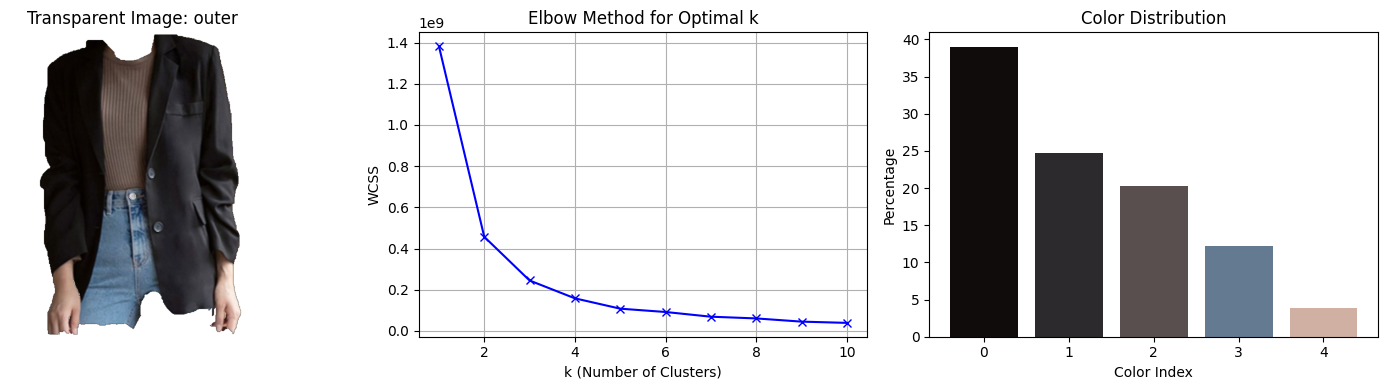


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#100c0b    (16, 12, 11)         39.0%
#2d2a2e    (45, 42, 46)         24.7%
#584f4e    (88, 79, 78)         20.3%
#647a91    (100, 122, 145)      12.1%
#d0b0a3    (208, 176, 163)      3.9%

Analyzing colors for pants


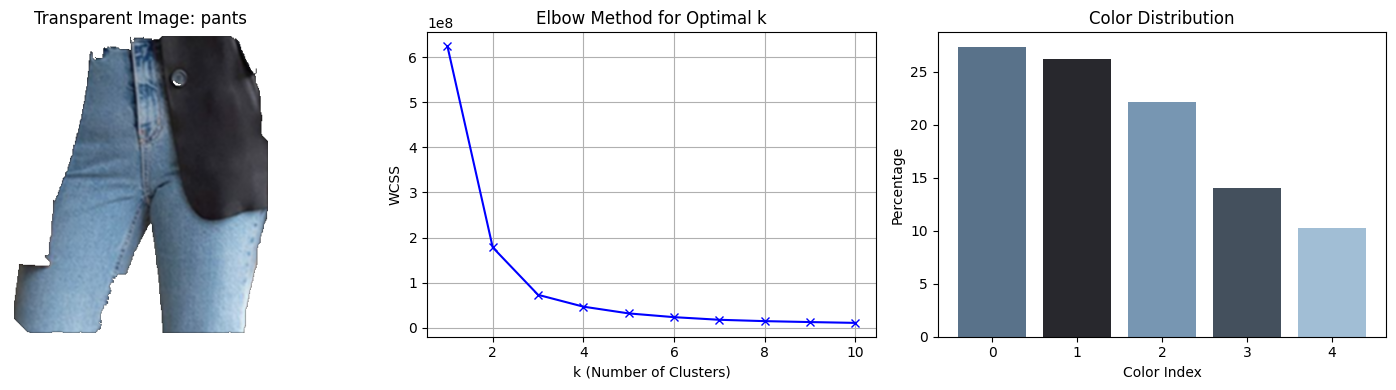


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#59728a    (89, 114, 138)       27.4%
#28282d    (40, 40, 45)         26.2%
#7796b2    (119, 150, 178)      22.1%
#44505d    (68, 80, 93)         14.0%
#a1bed5    (161, 190, 213)      10.3%

Analyzing colors for top


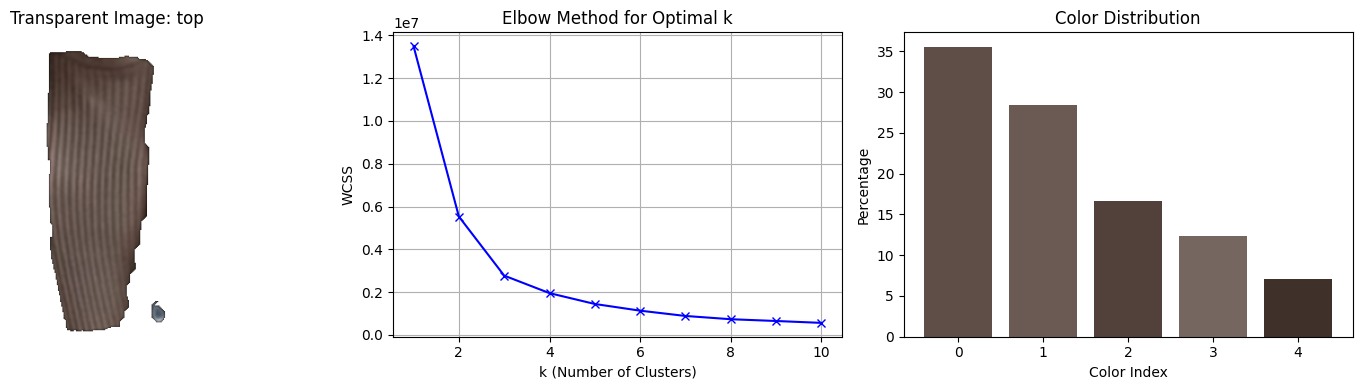


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#5e4e47    (94, 78, 71)         35.5%
#6a5a53    (106, 90, 83)        28.4%
#52413a    (82, 65, 58)         16.6%
#766660    (118, 102, 96)       12.4%
#3f3029    (63, 48, 41)         7.1%


In [9]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def rgb_to_hex(rgb):
    """RGB 값을 HEX 코드로 변환"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    """
    Elbow method를 위한 WCSS(Within-Cluster Sum of Squares) 계산
    """
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def extract_dominant_colors_transparent(rgba_image, n_colors=5):
    """
    투명 배경을 가진 RGBA 이미지에서 주요 색상을 추출하는 함수
    
    Args:
        rgba_image: RGBA 형식의 이미지 배열
        n_colors: 추출할 색상의 수
    
    Returns:
        colors: 주요 색상들의 RGB 값 리스트
        percentages: 각 색상의 비율
        pixels: 분석에 사용된 픽셀 데이터
    """
    # 알파 채널이 0이 아닌 픽셀만 선택 (배경이 아닌 부분)
    mask = rgba_image[:, :, 3] > 0
    
    # RGB 값만 사용하고 배경이 아닌 픽셀만 선택
    pixels = rgba_image[mask, :3]
    
    # 유효한 픽셀이 없는 경우 처리
    if len(pixels) == 0:
        return np.array([]), np.array([]), np.array([])
    
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    # 각 클러스터의 중심점(색상) 추출
    colors = kmeans.cluster_centers_
    
    # 각 픽셀이 속한 클러스터 레이블 확인
    labels = kmeans.labels_
    
    # 각 클러스터(색상)의 비율 계산
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())
    
    # 비율이 높은 순으로 정렬
    percentages = []
    sorted_colors = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        percentages.append(percentage)
        sorted_colors.append(colors[i])
    
    # 비율이 높은 순으로 정렬
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = np.array(sorted_colors)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]
    
    return sorted_colors, sorted_percentages, pixels

def visualize_color_palette(colors, percentages):
    """
    추출된 색상 팔레트를 시각화하는 함수
    
    Args:
        colors: RGB 색상 값 배열
        percentages: 각 색상의 비율
    """
    fig, ax = plt.subplots(figsize=(8, 1))
    
    # 각 색상을 개별 사각형으로 표시
    start_x = 0
    for i, (color, percentage) in enumerate(zip(colors, percentages)):
        width = percentage / 100
        
        # 색상 사각형 추가
        rect = Rectangle((start_x, 0), width, 1, 
                        facecolor=rgb_to_hex(color))
        ax.add_patch(rect)
        
        # HEX 코드와 비율 표시
        hex_code = rgb_to_hex(color)
        ax.text(start_x + width/2, 0.5, f'{hex_code}\n{percentage:.1f}%',
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
        
        start_x += width
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    return fig

def analyze_colors_for_transparent_objects(final_results, n_colors=5):
    """
    배경이 제거된 객체들의 색상을 분석하는 함수
    
    Args:
        final_results: (태그, RGBA_이미지) 튜플의 리스트
        n_colors: 각 객체당 추출할 색상의 수
    """
    for tag, rgba_img in final_results:
        print(f"\nAnalyzing colors for {tag}")
        
        # 주요 색상 추출 및 WCSS 계산
        colors, percentages, pixels = extract_dominant_colors_transparent(rgba_img, n_colors)
        
        if len(colors) == 0:
            print(f"No valid colors found for {tag}")
            continue
        
        wcss = calculate_wcss(pixels)
        
        # 서브플롯 설정
        fig = plt.figure(figsize=(15, 4))
        
        # 1. 원본 이미지
        plt.subplot(131)
        plt.imshow(rgba_img)
        plt.title(f"Transparent Image: {tag}")
        plt.axis('off')
        
        # 2. Elbow 곡선
        plt.subplot(132)
        plt.plot(range(1, len(wcss) + 1), wcss, 'bx-')
        plt.xlabel('k (Number of Clusters)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        
        # 3. 색상 팔레트
        plt.subplot(133)
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            plt.bar(i, percentage, color=rgb_to_hex(color), 
                   label=f'{rgb_to_hex(color)} ({percentage:.1f}%)')
        plt.title('Color Distribution')
        plt.xlabel('Color Index')
        plt.ylabel('Percentage')
        
        plt.tight_layout()
        plt.show()
        
        # 색상 정보 표로 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")

# 실행 예시
if final_results:  # final_results가 존재하는 경우에만 실행
    analyze_colors_for_transparent_objects(final_results)

### 클러스터링하여 성능 평가

#### RGB 3차원 Scatterplot으로 평가


Analyzing colors for outer


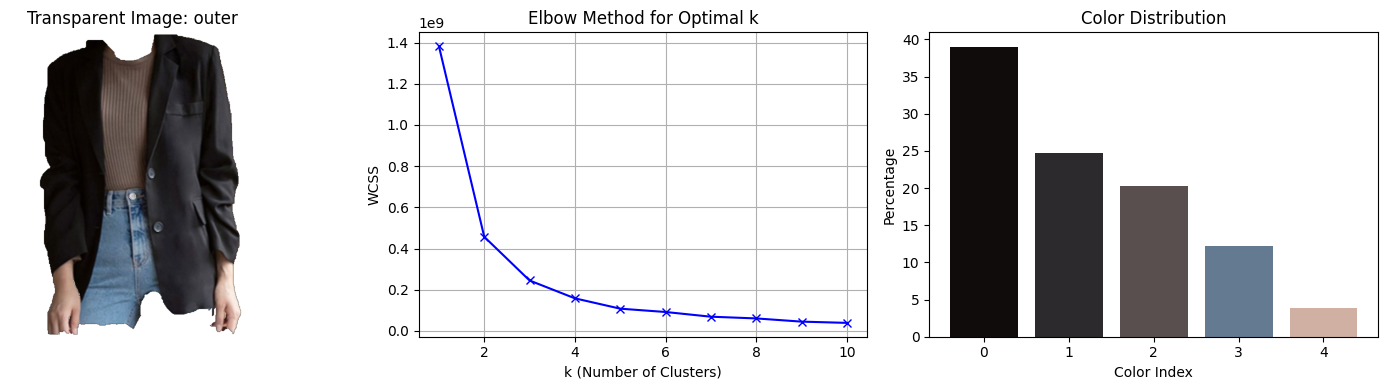

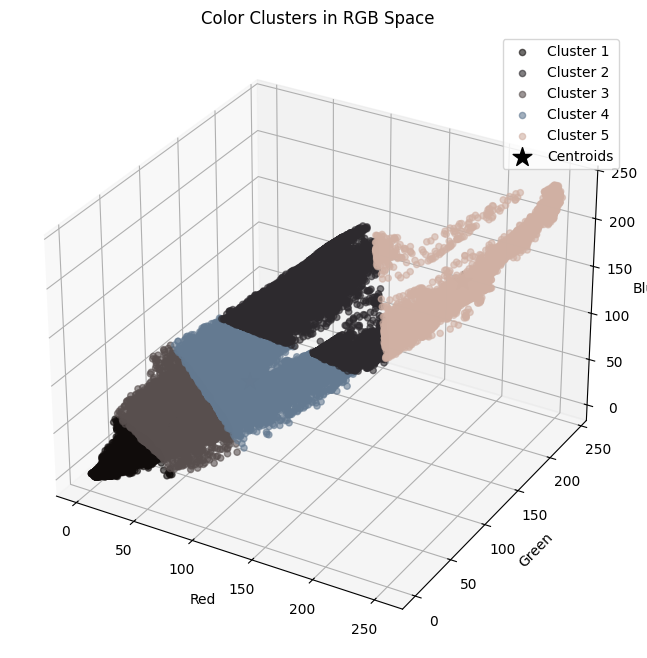


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#100c0b    (16, 12, 11)         39.0%
#2d2a2e    (45, 42, 46)         24.7%
#584f4e    (88, 79, 78)         20.3%
#647a91    (100, 122, 145)      12.1%
#d0b0a3    (208, 176, 163)      3.9%

Analyzing colors for pants


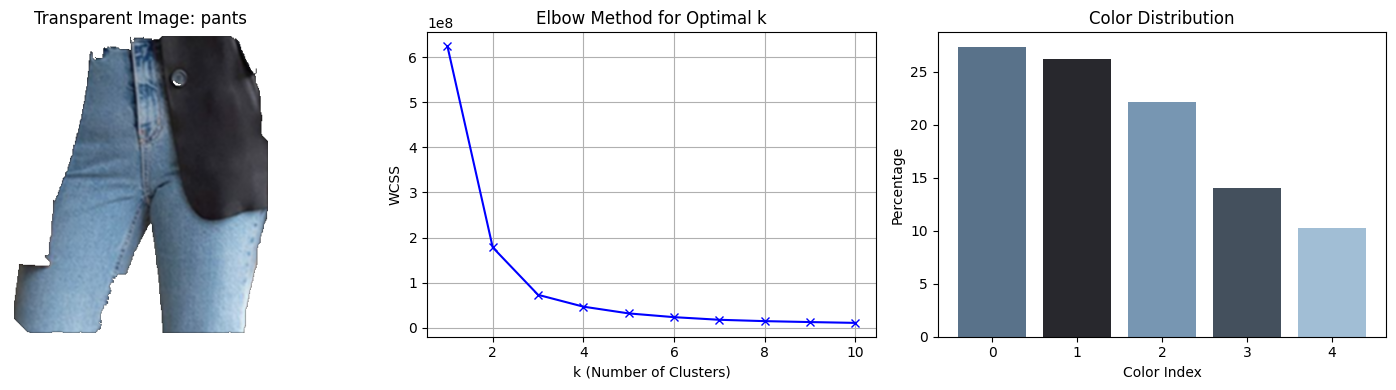

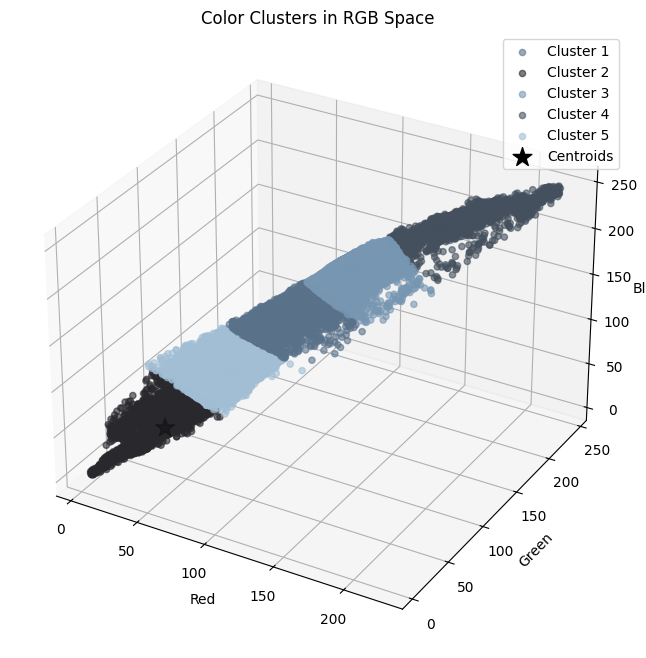


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#59728a    (89, 114, 138)       27.4%
#28282d    (40, 40, 45)         26.2%
#7796b2    (119, 150, 178)      22.1%
#44505d    (68, 80, 93)         14.0%
#a1bed5    (161, 190, 213)      10.3%

Analyzing colors for top


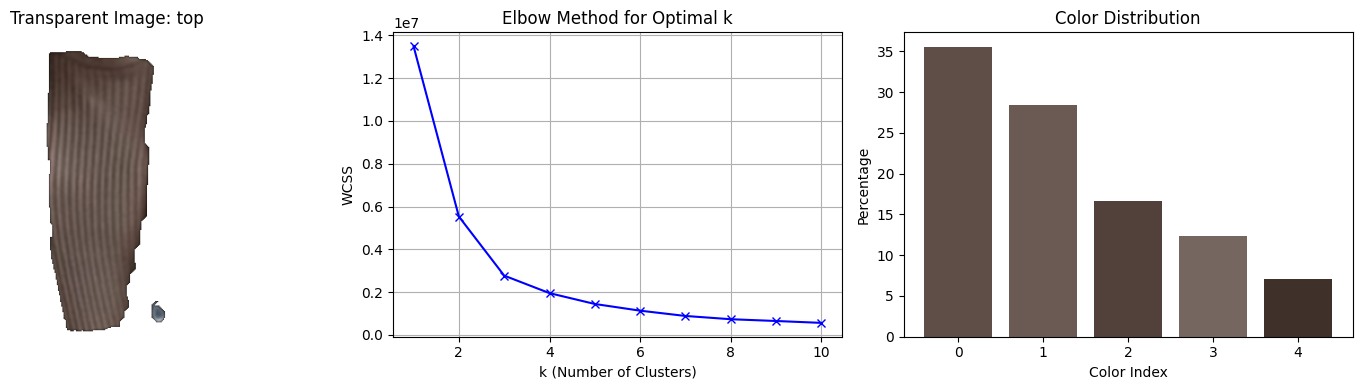

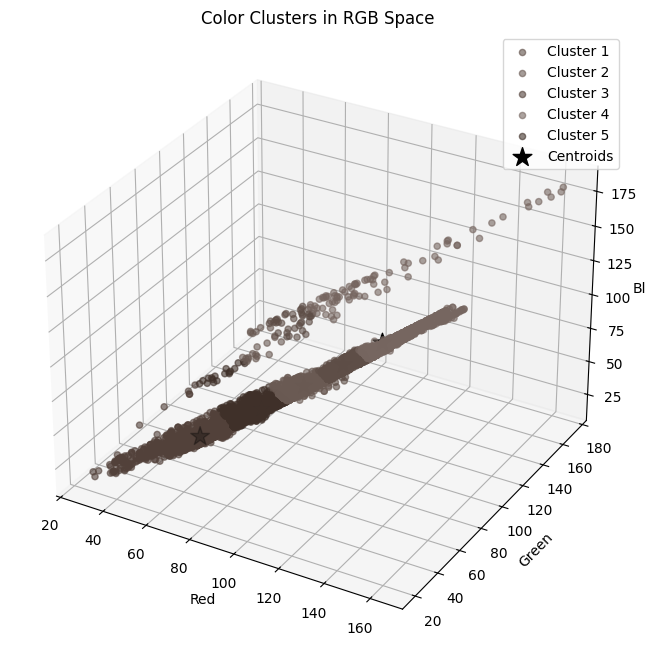


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#5e4e47    (94, 78, 71)         35.5%
#6a5a53    (106, 90, 83)        28.4%
#52413a    (82, 65, 58)         16.6%
#766660    (118, 102, 96)       12.4%
#3f3029    (63, 48, 41)         7.1%


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def rgb_to_hex(rgb):
    """RGB 값을 HEX 코드로 변환"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    """
    Elbow method를 위한 WCSS(Within-Cluster Sum of Squares) 계산
    """
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def plot_color_clusters(pixels, kmeans, colors):
    """
    K-means 클러스터링 결과를 3D scatter plot으로 시각화
    
    Args:
        pixels: 분석에 사용된 픽셀 데이터
        kmeans: 학습된 KMeans 모델
        colors: 추출된 주요 색상들
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 각 클러스터별로 점들을 다른 색상으로 표시
    for i in range(len(colors)):
        cluster_points = pixels[kmeans.labels_ == i]
        ax.scatter(cluster_points[:, 0], 
                  cluster_points[:, 1], 
                  cluster_points[:, 2],
                  c=[rgb_to_hex(colors[i])],
                  label=f'Cluster {i+1}',
                  alpha=0.6)
    
    # 클러스터 중심점 표시
    ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2],
              c='black', marker='*', s=200,
              label='Centroids')
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Color Clusters in RGB Space')
    ax.legend()
    
    return fig

def extract_dominant_colors_transparent(rgba_image, n_colors=5):
    """
    투명 배경을 가진 RGBA 이미지에서 주요 색상을 추출하는 함수
    
    Args:
        rgba_image: RGBA 형식의 이미지 배열
        n_colors: 추출할 색상의 수
    
    Returns:
        colors: 주요 색상들의 RGB 값 리스트
        percentages: 각 색상의 비율
        pixels: 분석에 사용된 픽셀 데이터
        kmeans: 학습된 KMeans 모델
    """
    # 알파 채널이 0이 아닌 픽셀만 선택 (배경이 아닌 부분)
    mask = rgba_image[:, :, 3] > 0
    
    # RGB 값만 사용하고 배경이 아닌 픽셀만 선택
    pixels = rgba_image[mask, :3]
    
    # 유효한 픽셀이 없는 경우 처리
    if len(pixels) == 0:
        return np.array([]), np.array([]), np.array([]), None
    
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    # 각 클러스터의 중심점(색상) 추출
    colors = kmeans.cluster_centers_
    
    # 각 픽셀이 속한 클러스터 레이블 확인
    labels = kmeans.labels_
    
    # 각 클러스터(색상)의 비율 계산
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())
    
    # 비율이 높은 순으로 정렬
    percentages = []
    sorted_colors = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        percentages.append(percentage)
        sorted_colors.append(colors[i])
    
    # 비율이 높은 순으로 정렬
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = np.array(sorted_colors)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]
    
    return sorted_colors, sorted_percentages, pixels, kmeans

def visualize_color_palette(colors, percentages):
    """
    추출된 색상 팔레트를 시각화하는 함수
    
    Args:
        colors: RGB 색상 값 배열
        percentages: 각 색상의 비율
    """
    fig, ax = plt.subplots(figsize=(8, 1))
    
    # 각 색상을 개별 사각형으로 표시
    start_x = 0
    for i, (color, percentage) in enumerate(zip(colors, percentages)):
        width = percentage / 100
        
        # 색상 사각형 추가
        rect = Rectangle((start_x, 0), width, 1, 
                        facecolor=rgb_to_hex(color))
        ax.add_patch(rect)
        
        # HEX 코드와 비율 표시
        hex_code = rgb_to_hex(color)
        ax.text(start_x + width/2, 0.5, f'{hex_code}\n{percentage:.1f}%',
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
        
        start_x += width
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    return fig

def analyze_colors_for_transparent_objects(final_results, n_colors=5):
    """
    배경이 제거된 객체들의 색상을 분석하는 함수
    
    Args:
        final_results: (태그, RGBA_이미지) 튜플의 리스트
        n_colors: 각 객체당 추출할 색상의 수
    """
    for tag, rgba_img in final_results:
        print(f"\nAnalyzing colors for {tag}")
        
        # 주요 색상 추출 및 WCSS 계산
        colors, percentages, pixels, kmeans = extract_dominant_colors_transparent(rgba_img, n_colors)
        
        if len(colors) == 0:
            print(f"No valid colors found for {tag}")
            continue
        
        wcss = calculate_wcss(pixels)
        
        # 서브플롯 설정 (3개 그래프만 포함)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # 1. 원본 이미지
        axes[0].imshow(rgba_img)
        axes[0].set_title(f"Transparent Image: {tag}")
        axes[0].axis('off')
        
        # 2. Elbow 곡선
        axes[1].plot(range(1, len(wcss) + 1), wcss, 'bx-')
        axes[1].set_xlabel('k (Number of Clusters)')
        axes[1].set_ylabel('WCSS')
        axes[1].set_title('Elbow Method for Optimal k')
        axes[1].grid(True)
        
        # 3. 색상 팔레트
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            axes[2].bar(i, percentage, color=rgb_to_hex(color), 
                        label=f'{rgb_to_hex(color)} ({percentage:.1f}%)')
        axes[2].set_title('Color Distribution')
        axes[2].set_xlabel('Color Index'
        axes[2].set_ylabel('Percentage')
        
        plt.tight_layout()
        plt.show()
        
        # 4. 별도의 3D scatter plot 출력
        scatter_fig = plot_color_clusters(pixels, kmeans, colors)
        plt.show()
        
        # 색상 정보 표로 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")

# 실행 예시
if final_results:  # final_results가 존재하는 경우에만 실행
    analyze_colors_for_transparent_objects(final_results)


Analyzing colors for outer


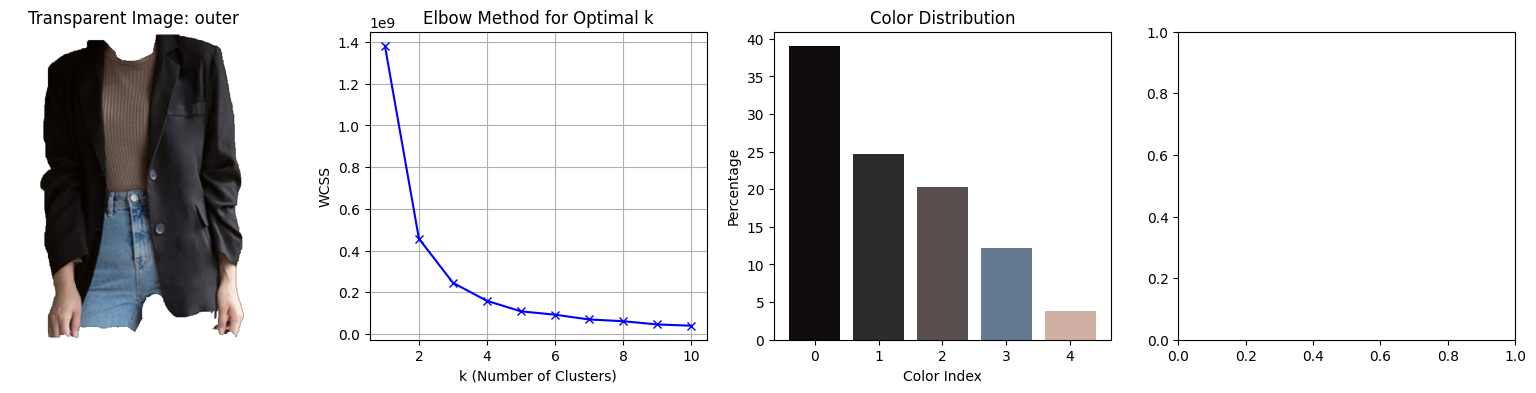

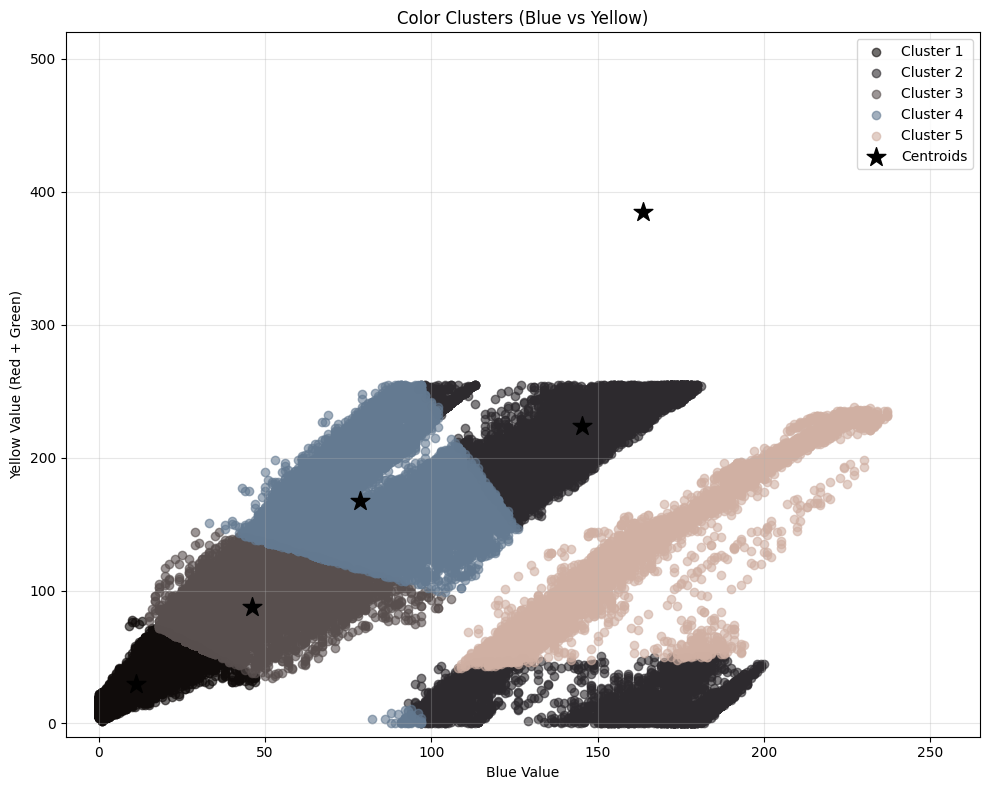


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#100c0b    (16, 12, 11)         39.0%
#2d2a2e    (45, 42, 46)         24.7%
#584f4e    (88, 79, 78)         20.3%
#647a91    (100, 122, 145)      12.1%
#d0b0a3    (208, 176, 163)      3.9%

Analyzing colors for pants


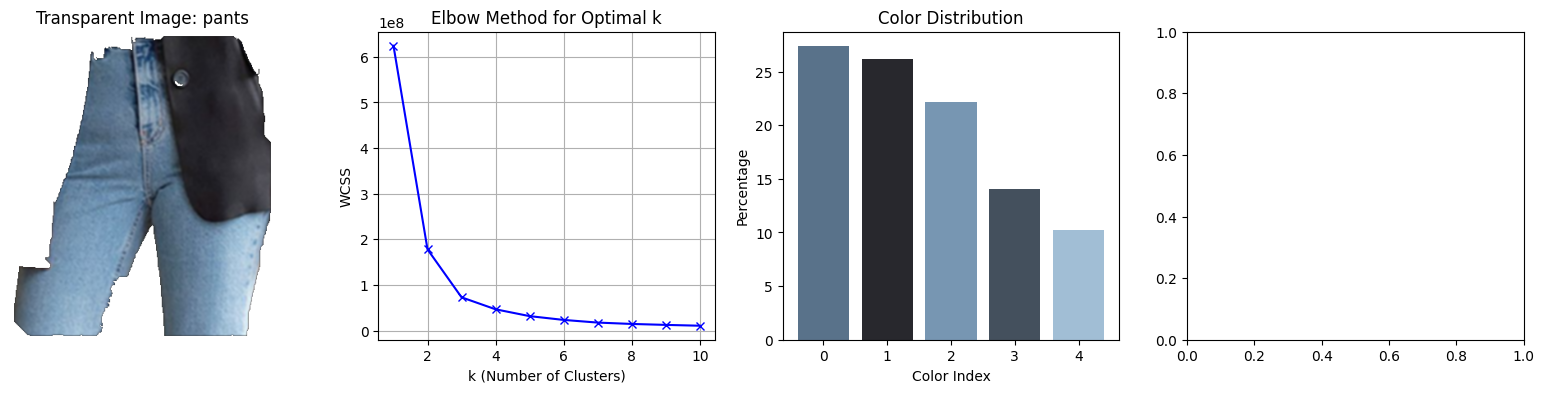

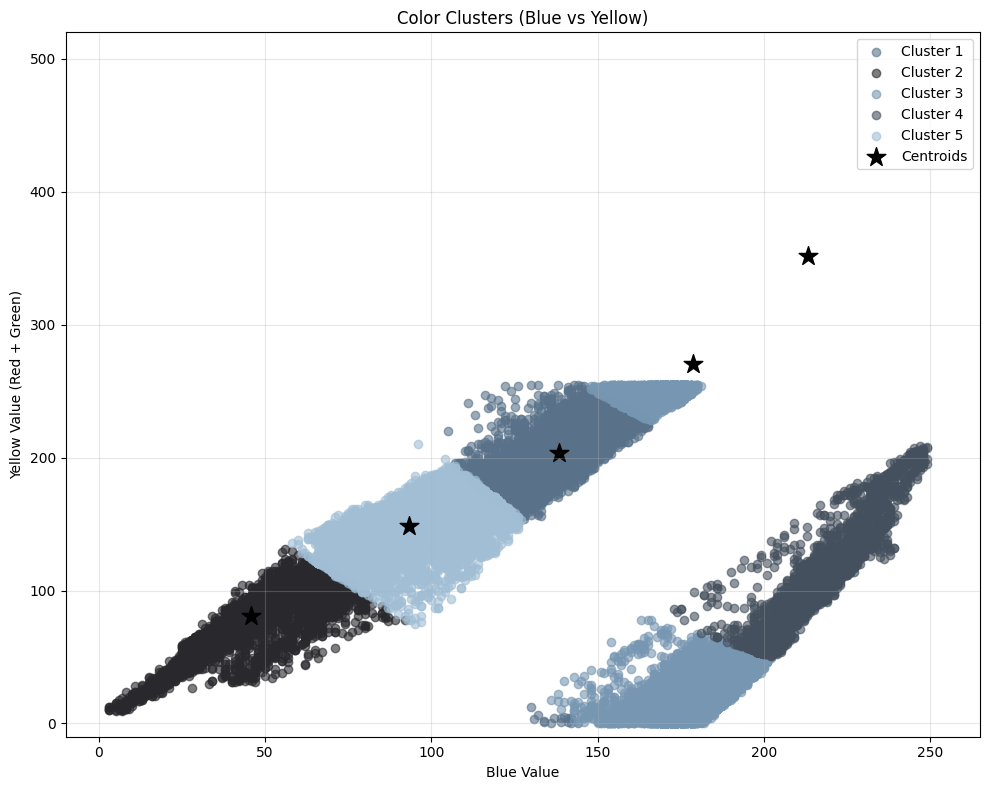


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#59728a    (89, 114, 138)       27.4%
#28282d    (40, 40, 45)         26.2%
#7796b2    (119, 150, 178)      22.1%
#44505d    (68, 80, 93)         14.0%
#a1bed5    (161, 190, 213)      10.3%

Analyzing colors for top


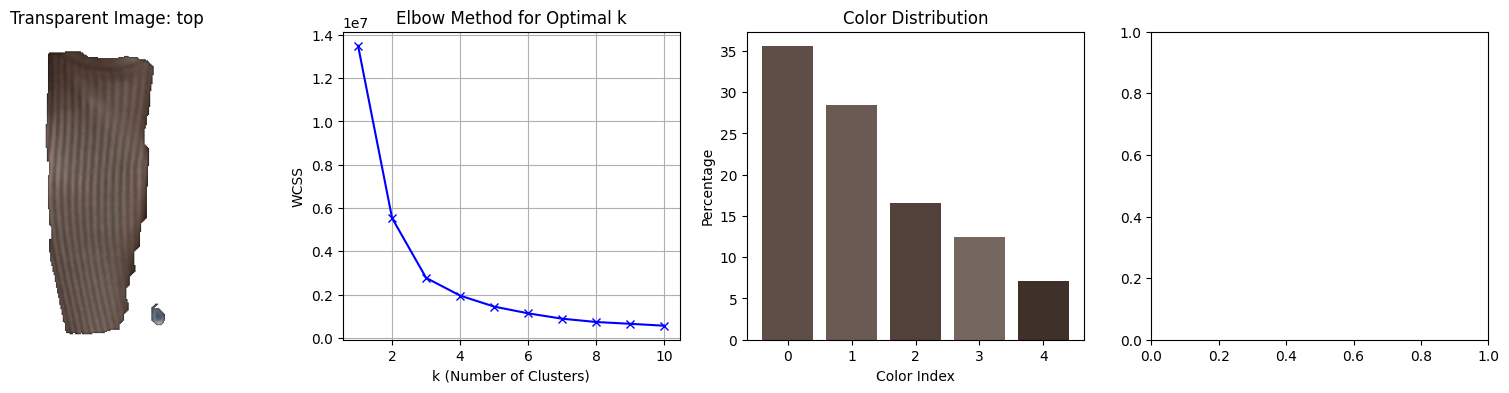

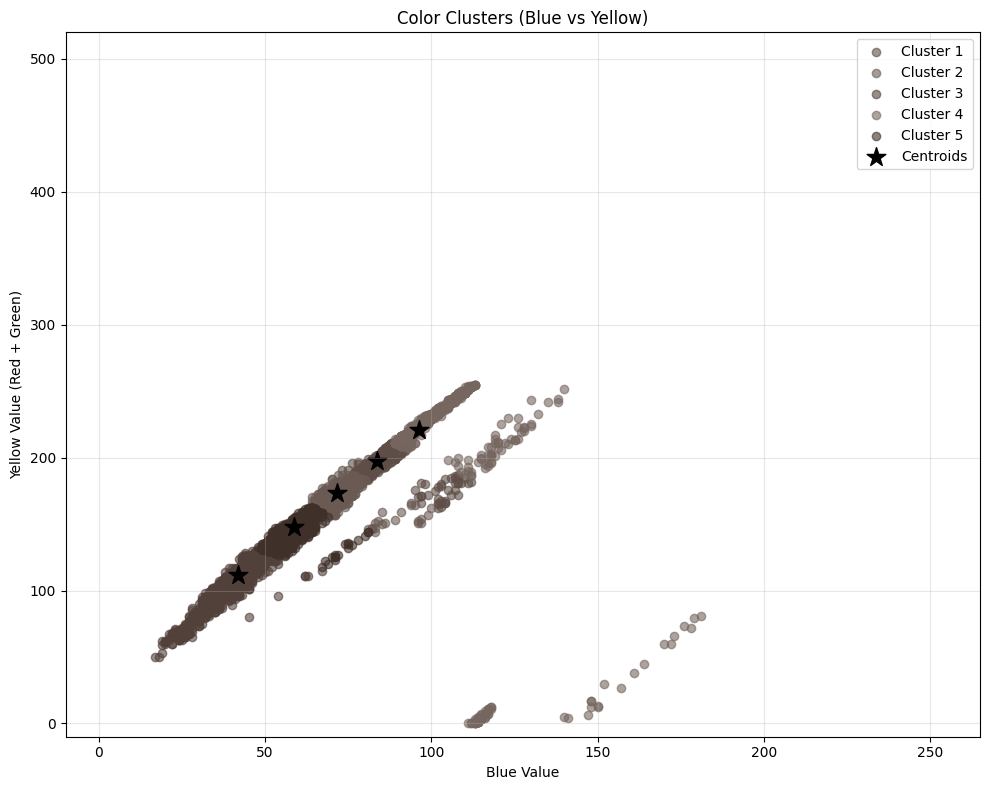


Dominant colors:
HEX Code   RGB Values           Percentage
----------------------------------------
#5e4e47    (94, 78, 71)         35.5%
#6a5a53    (106, 90, 83)        28.4%
#52413a    (82, 65, 58)         16.6%
#766660    (118, 102, 96)       12.4%
#3f3029    (63, 48, 41)         7.1%


In [52]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def rgb_to_hex(rgb):
    """RGB 값을 HEX 코드로 변환"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def calculate_wcss(pixels, max_k=10):
    """
    Elbow method를 위한 WCSS(Within-Cluster Sum of Squares) 계산
    """
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        wcss.append(kmeans.inertia_)
    return wcss

def plot_color_clusters_2d(pixels, kmeans, colors):
    """
    K-means 클러스터링 결과를 2D scatter plot으로 시각화
    x축: Blue
    y축: Yellow (Red + Green)
    
    Args:
        pixels: 분석에 사용된 픽셀 데이터 (RGB)
        kmeans: 학습된 KMeans 모델
        colors: 추출된 주요 색상들
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # RGB를 Blue와 Yellow(Red+Green) 값으로 변환
    blue_values = pixels[:, 2]  # Blue 값
    yellow_values = pixels[:, 0] + pixels[:, 1]  # Red + Green 값
    
    # 클러스터 중심점도 같은 방식으로 변환
    centroids_blue = colors[:, 2]
    centroids_yellow = colors[:, 0] + colors[:, 1]
    
    # 각 클러스터별로 점들을 다른 색상으로 표시
    for i in range(len(colors)):
        cluster_mask = kmeans.labels_ == i
        ax.scatter(blue_values[cluster_mask], 
                  yellow_values[cluster_mask],
                  c=[rgb_to_hex(colors[i])],
                  label=f'Cluster {i+1}',
                  alpha=0.6)
    
    # 클러스터 중심점 표시
    ax.scatter(centroids_blue, centroids_yellow,
              c='black', marker='*', s=200,
              label='Centroids')
    
    ax.set_xlabel('Blue Value')
    ax.set_ylabel('Yellow Value (Red + Green)')
    ax.set_title('Color Clusters in Blue-Yellow Space')
    ax.legend()
    
    # 축 범위 설정 (RGB 값의 범위는 0-255이지만, Yellow는 Red+Green이므로 0-510)
    ax.set_xlim(-10, 265)  # Blue 축
    ax.set_ylim(-10, 520)  # Yellow 축
    
    # 그리드 추가
    ax.grid(True, alpha=0.3)
    
    return fig

def extract_dominant_colors_transparent(rgba_image, n_colors=5):
    """
    투명 배경을 가진 RGBA 이미지에서 주요 색상을 추출하는 함수
    
    Args:
        rgba_image: RGBA 형식의 이미지 배열
        n_colors: 추출할 색상의 수
    
    Returns:
        colors: 주요 색상들의 RGB 값 리스트
        percentages: 각 색상의 비율
        pixels: 분석에 사용된 픽셀 데이터
        kmeans: 학습된 KMeans 모델
    """
    # 알파 채널이 0이 아닌 픽셀만 선택 (배경이 아닌 부분)
    mask = rgba_image[:, :, 3] > 0
    
    # RGB 값만 사용하고 배경이 아닌 픽셀만 선택
    pixels = rgba_image[mask, :3]
    
    # 유효한 픽셀이 없는 경우 처리
    if len(pixels) == 0:
        return np.array([]), np.array([]), np.array([]), None
    
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    # 각 클러스터의 중심점(색상) 추출
    colors = kmeans.cluster_centers_
    
    # 각 픽셀이 속한 클러스터 레이블 확인
    labels = kmeans.labels_
    
    # 각 클러스터(색상)의 비율 계산
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())
    
    # 비율이 높은 순으로 정렬
    percentages = []
    sorted_colors = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        percentages.append(percentage)
        sorted_colors.append(colors[i])
    
    # 비율이 높은 순으로 정렬
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_colors = np.array(sorted_colors)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]
    
    return sorted_colors, sorted_percentages, pixels, kmeans

def visualize_color_palette(colors, percentages):
    """
    추출된 색상 팔레트를 시각화하는 함수
    
    Args:
        colors: RGB 색상 값 배열
        percentages: 각 색상의 비율
    """
    fig, ax = plt.subplots(figsize=(8, 1))
    
    # 각 색상을 개별 사각형으로 표시
    start_x = 0
    for i, (color, percentage) in enumerate(zip(colors, percentages)):
        width = percentage / 100
        
        # 색상 사각형 추가
        rect = Rectangle((start_x, 0), width, 1, 
                        facecolor=rgb_to_hex(color))
        ax.add_patch(rect)
        
        # HEX 코드와 비율 표시
        hex_code = rgb_to_hex(color)
        ax.text(start_x + width/2, 0.5, f'{hex_code}\n{percentage:.1f}%',
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
        
        start_x += width
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    return fig

def analyze_colors_for_transparent_objects(final_results, n_colors=5):
    """
    배경이 제거된 객체들의 색상을 분석하는 함수
    
    Args:
        final_results: (태그, RGBA_이미지) 튜플의 리스트
        n_colors: 각 객체당 추출할 색상의 수
    """
    for tag, rgba_img in final_results:
        print(f"\nAnalyzing colors for {tag}")
        
        # 주요 색상 추출 및 WCSS 계산
        colors, percentages, pixels, kmeans = extract_dominant_colors_transparent(rgba_img, n_colors)
        
        if len(colors) == 0:
            print(f"No valid colors found for {tag}")
            continue
        
        wcss = calculate_wcss(pixels)
        
        # 서브플롯 설정
        fig = plt.figure(figsize=(20, 4))
        
        # 1. 원본 이미지
        plt.subplot(141)
        plt.imshow(rgba_img)
        plt.title(f"Transparent Image: {tag}")
        plt.axis('off')
        
        # 2. Elbow 곡선
        plt.subplot(142)
        plt.plot(range(1, len(wcss) + 1), wcss, 'bx-')
        plt.xlabel('k (Number of Clusters)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        
        # 3. 색상 팔레트
        plt.subplot(143)
        for i, (color, percentage) in enumerate(zip(colors, percentages)):
            plt.bar(i, percentage, color=rgb_to_hex(color), 
                   label=f'{rgb_to_hex(color)} ({percentage:.1f}%)')
        plt.title('Color Distribution')
        plt.xlabel('Color Index')
        plt.ylabel('Percentage')
        
        # 4. 2D scatter plot (Blue-Yellow)
        plt.subplot(144)
        scatter_fig = plot_color_clusters_2d(pixels, kmeans, colors)
        plt.title('Color Clusters (Blue vs Yellow)')
        
        plt.tight_layout()
        plt.show()
        
        # 색상 정보 표로 출력
        print("\nDominant colors:")
        print(f"{'HEX Code':<10} {'RGB Values':<20} {'Percentage':<10}")
        print("-" * 40)
        for color, percentage in zip(colors, percentages):
            hex_code = rgb_to_hex(color)
            rgb_str = f"({int(color[0])}, {int(color[1])}, {int(color[2])})"
            print(f"{hex_code:<10} {rgb_str:<20} {percentage:.1f}%")

# 실행 예시
if final_results:  # final_results가 존재하는 경우에만 실행
    analyze_colors_for_transparent_objects(final_results)